In [1]:
# Step 1: Setup and Data Preparation

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('TSLA.csv')

In [2]:
# Preview data
print(df.head())
print("\nSummary Info:")
print(df.info())

         Date   Open   High    Low  Close  Adj Close    Volume
0  2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
1  2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2  2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
3  2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
4  2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500

Summary Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2956 non-null   object 
 1   Open       2956 non-null   float64
 2   High       2956 non-null   float64
 3   Low        2956 non-null   float64
 4   Close      2956 non-null   float64
 5   Adj Close  2956 non-null   float64
 6   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.8+ KB
None


In [3]:
# Parse date and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Sort by date
df.sort_index(inplace=True)

In [4]:
# Check for missing values
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [5]:
# Drop rows with nulls or interpolate (if minor)
df = df[['Close']].dropna()  # focus only on 'Close' price

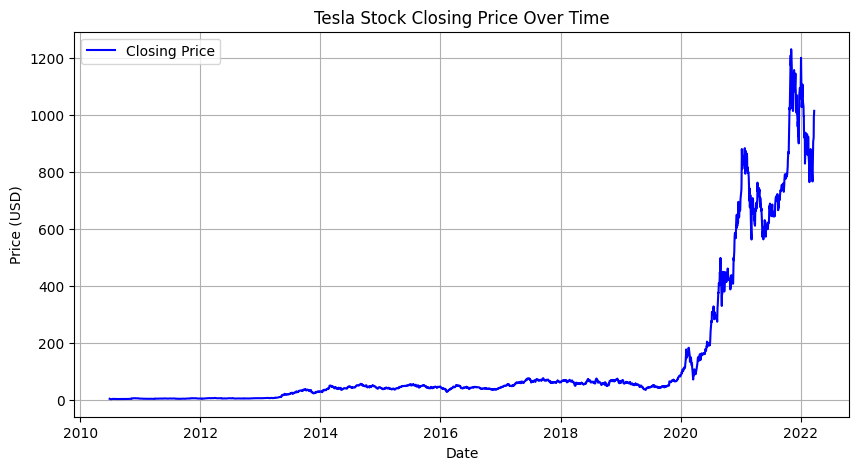

In [6]:
# Step 2: Exploratory Time Series Analysis

# Plot closing prices over time
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Closing Price', color='blue')
plt.title("Tesla Stock Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Rolling Mean and Standard Deviation
rolling_mean = df['Close'].rolling(window=30).mean()   # 30-day moving average
rolling_std = df['Close'].rolling(window=30).std()     # 30-day standard deviation

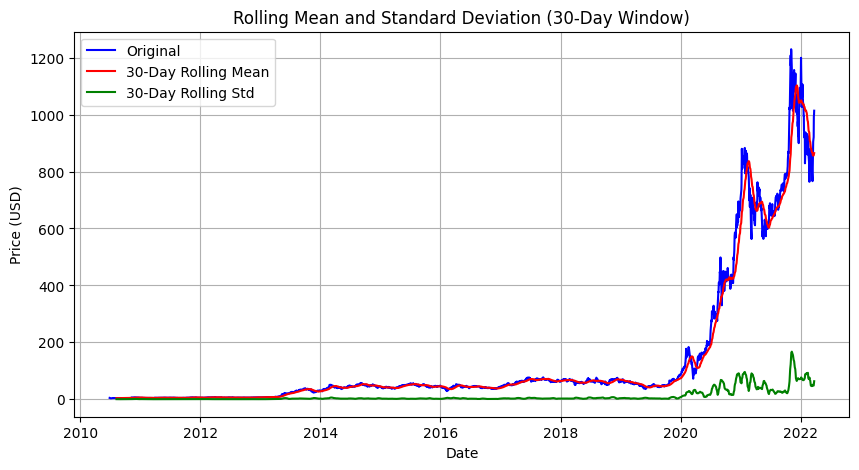

In [8]:
# Plot rolling statistics
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Original', color='blue')
plt.plot(rolling_mean, label='30-Day Rolling Mean', color='red')
plt.plot(rolling_std, label='30-Day Rolling Std', color='green')
plt.title('Rolling Mean and Standard Deviation (30-Day Window)')
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
'''
1. Strong Upward Trend (Post-2019):
- From around late 2019, Tesla’s stock began a significant upward trend.
- The 30-day rolling mean (red line) closely follows the original price (blue), confirming a consistent and long-term increase.
- This kind of trend often suggests the need for differencing when modeling with ARIMA.

2. Low and Stable Volatility (Before 2020), Higher Volatility After:
- The 30-day rolling standard deviation (green line) was quite flat and low until about 2019.
- After 2020, there's a clear increase in volatility — this is typical of financial markets during growth spurts or macroeconomic uncertainty (e.g., COVID-19 era, Tesla S&P 500 inclusion).
- This suggests the series has changing variance, which might make a multiplicative model more appropriate.

3. Seasonality Is Not Obvious Visually:
-There's no immediately visible cyclical pattern like weekly, monthly, or annual repeating structure.
-But that doesn't mean there's none — we’ll check this via decomposition in the next step.

'''

"\n1. Strong Upward Trend (Post-2019):\n- From around late 2019, Tesla’s stock began a significant upward trend.\n- The 30-day rolling mean (red line) closely follows the original price (blue), confirming a consistent and long-term increase.\n- This kind of trend often suggests the need for differencing when modeling with ARIMA.\n\n2. Low and Stable Volatility (Before 2020), Higher Volatility After:\n- The 30-day rolling standard deviation (green line) was quite flat and low until about 2019.\n- After 2020, there's a clear increase in volatility — this is typical of financial markets during growth spurts or macroeconomic uncertainty (e.g., COVID-19 era, Tesla S&P 500 inclusion).\n- This suggests the series has changing variance, which might make a multiplicative model more appropriate.\n\n3. Seasonality Is Not Obvious Visually:\n-There's no immediately visible cyclical pattern like weekly, monthly, or annual repeating structure.\n-But that doesn't mean there's none — we’ll check this v

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Step 3: Decomposition

# Resample to monthly frequency to smooth out noise and reduce irregularities
monthly_data = df['Close'].resample('M').mean()

# Additive Decomposition
additive_decomp = seasonal_decompose(monthly_data, model='additive', period=12)

# Multiplicative Decomposition
multiplicative_decomp = seasonal_decompose(monthly_data, model='multiplicative', period=12)

<Figure size 1200x800 with 0 Axes>

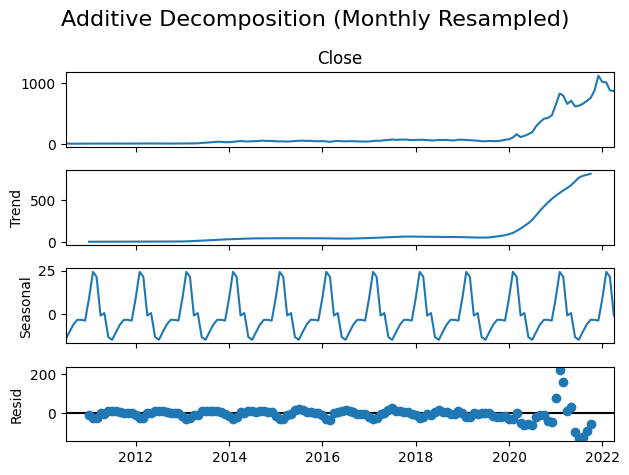

In [11]:
# Plot Additive Decomposition
plt.figure(figsize=(12, 8))
additive_decomp.plot()
plt.suptitle('Additive Decomposition (Monthly Resampled)', fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

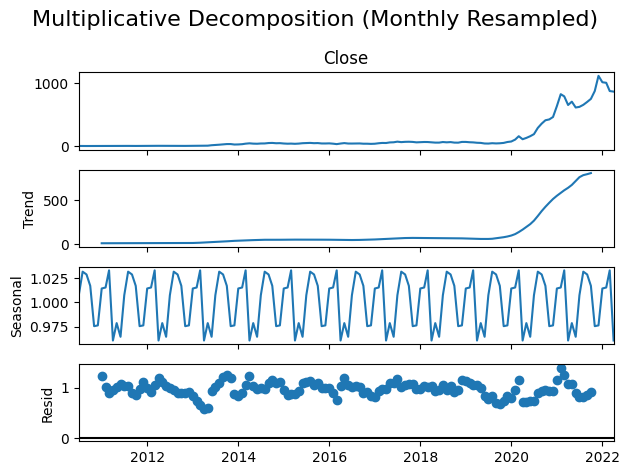

In [12]:
# Plot Multiplicative Decomposition
plt.figure(figsize=(12, 8))
multiplicative_decomp.plot()
plt.suptitle('Multiplicative Decomposition (Monthly Resampled)', fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
'''
1. Trend Component (both models)
- Shows a strong upward movement starting around 2019–2020, matching Tesla’s rapid stock growth.
2. Seasonal Component
- Additive Seasonality (varies by ~25 units):
- Seasonal patterns repeat regularly, especially in yearly cycles (peaks and dips at same times each year).
- Multiplicative Seasonality (values oscillate between ~0.975 and ~1.025):
- Seasonality is proportional to the trend — as prices increase, seasonal variation becomes amplified in absolute terms.
- Multiplicative model handles proportional change better, which is ideal for financial time series like this.

3. Residuals (Noise)
- Additive Residuals: Show non-random structure after 2020 — large unexplained spikes → model can't handle large-scale change well.
- Multiplicative Residuals: Appear more random and stable, even during high-growth periods, which is desirable for a well-fit model.

Conclusion:
 The multiplicative decomposition is more appropriate for Tesla’s stock data due to proportional seasonal fluctuations and stable residuals.
'''

"\n1. Trend Component (both models)\n- Shows a strong upward movement starting around 2019–2020, matching Tesla’s rapid stock growth.\n2. Seasonal Component\n- Additive Seasonality (varies by ~25 units):\n- Seasonal patterns repeat regularly, especially in yearly cycles (peaks and dips at same times each year).\n- Multiplicative Seasonality (values oscillate between ~0.975 and ~1.025):\n- Seasonality is proportional to the trend — as prices increase, seasonal variation becomes amplified in absolute terms.\n- Multiplicative model handles proportional change better, which is ideal for financial time series like this.\n\n3. Residuals (Noise)\n- Additive Residuals: Show non-random structure after 2020 — large unexplained spikes → model can't handle large-scale change well.\n- Multiplicative Residuals: Appear more random and stable, even during high-growth periods, which is desirable for a well-fit model.\n\nConclusion:\n The multiplicative decomposition is more appropriate for Tesla’s stoc

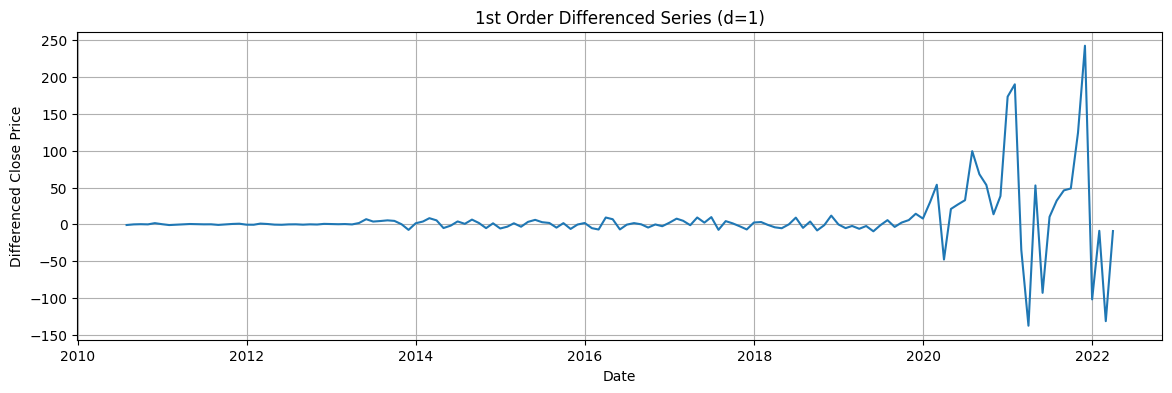

In [14]:
#Step 4: ACF and PACF Analysis
#Use first-order differencing (d=1)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 4.1: Differencing to remove trend
diff_series = monthly_data.diff().dropna()

# Plot differenced series
plt.figure(figsize=(14, 4))
plt.plot(diff_series)
plt.title("1st Order Differenced Series (d=1)")
plt.xlabel("Date")
plt.ylabel("Differenced Close Price")
plt.grid(True)
plt.show()


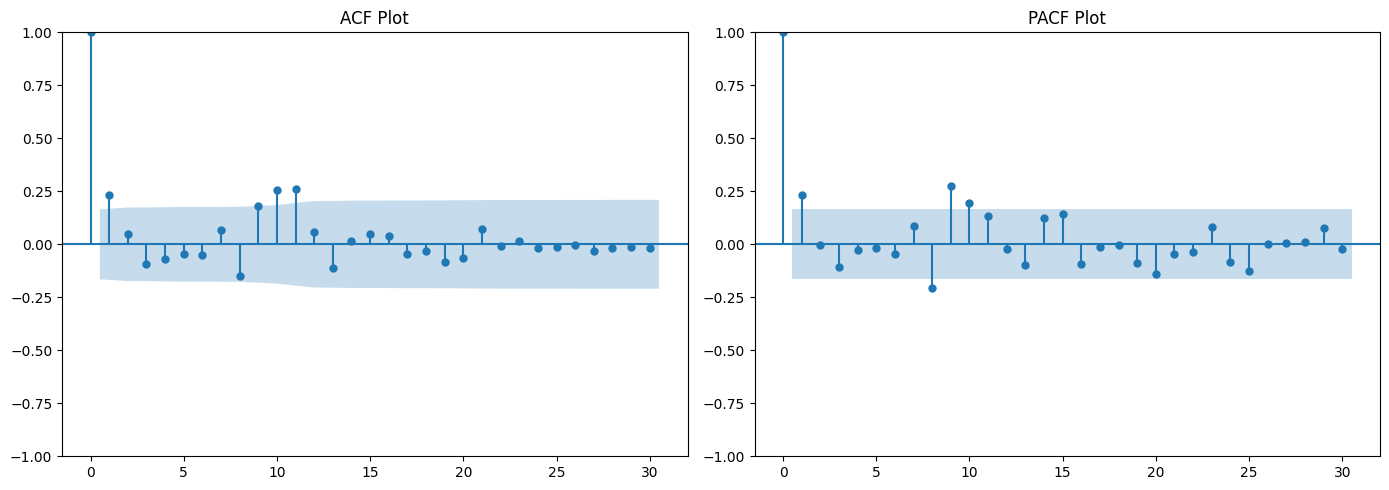

In [15]:
# Step 4.2: Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(diff_series, lags=30, ax=axes[0])
axes[0].set_title("ACF Plot")

plot_pacf(diff_series, lags=30, ax=axes[1], method='ywm')
axes[1].set_title("PACF Plot")

plt.tight_layout()
plt.show()


In [16]:
'''
Interpretation of ACF & PACF Plots

Differenced Series:
- The differenced series looks reasonably stationary, especially before 2020.
- Large spikes after 2020 suggest recent volatility.

ACF Plot (Autocorrelation)
- Lag 1 has a strong spike — this is expected.
- After lag 1, most points fall within confidence bounds, except some minor spikes around lags 10 and 12.
- This pattern suggests a short MA component: q = 1

PACF Plot (Partial Autocorrelation)
- Strong spike at lag 1, then cuts off quickly.
- Minor fluctuations after that are likely noise.

Suggests a short AR component: p = 1
'''

'\nInterpretation of ACF & PACF Plots\n\nDifferenced Series:\n- The differenced series looks reasonably stationary, especially before 2020.\n- Large spikes after 2020 suggest recent volatility.\n\nACF Plot (Autocorrelation)\n- Lag 1 has a strong spike — this is expected.\n- After lag 1, most points fall within confidence bounds, except some minor spikes around lags 10 and 12.\n- This pattern suggests a short MA component: q = 1\n\nPACF Plot (Partial Autocorrelation)\n- Strong spike at lag 1, then cuts off quickly.\n- Minor fluctuations after that are likely noise.\n\nSuggests a short AR component: p = 1\n'

In [17]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Step 5.1: Train-Test Split
train = monthly_data.iloc[:-12]
test = monthly_data.iloc[-12:]

print(f"Train size: {len(train)} months")
print(f"Test size: {len(test)} months")


Train size: 130 months
Test size: 12 months


In [18]:
# Step 5.2: Fit ARIMA(1,1,1)
arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()

# Forecast next 12 months
forecast_arima = arima_result.forecast(steps=12)


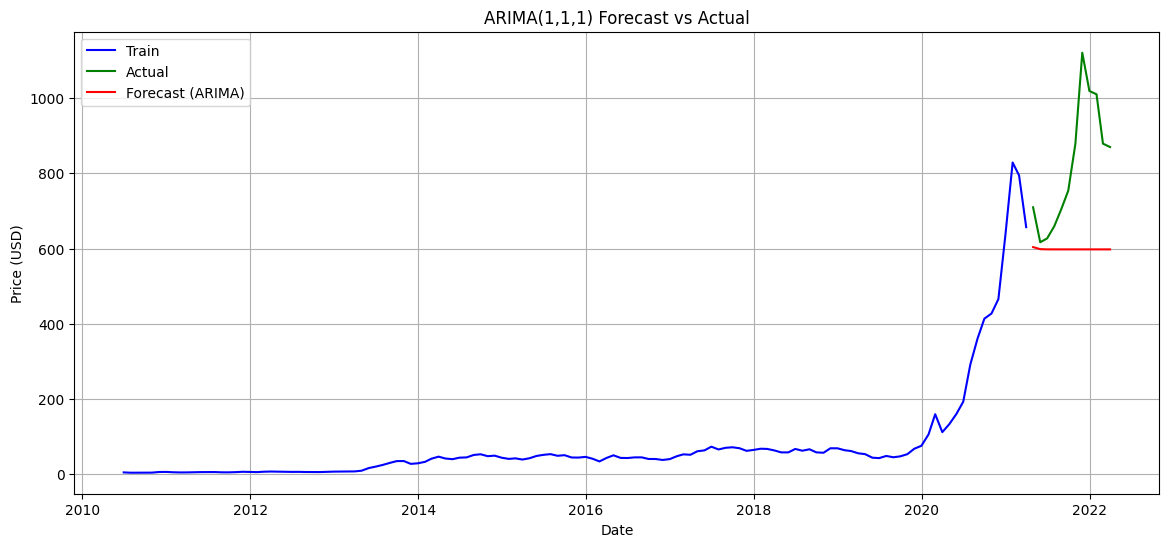

In [19]:
# Step 5.3: Plot actual vs forecasted
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label="Train", color='blue')
plt.plot(test.index, test, label="Actual", color='green')
plt.plot(test.index, forecast_arima, label="Forecast (ARIMA)", color='red')
plt.title("ARIMA(1,1,1) Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 5.4: Fit SARIMA Model
sarima_model = SARIMAX(train,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Forecast next 12 months
forecast_sarima = sarima_result.forecast(steps=12)


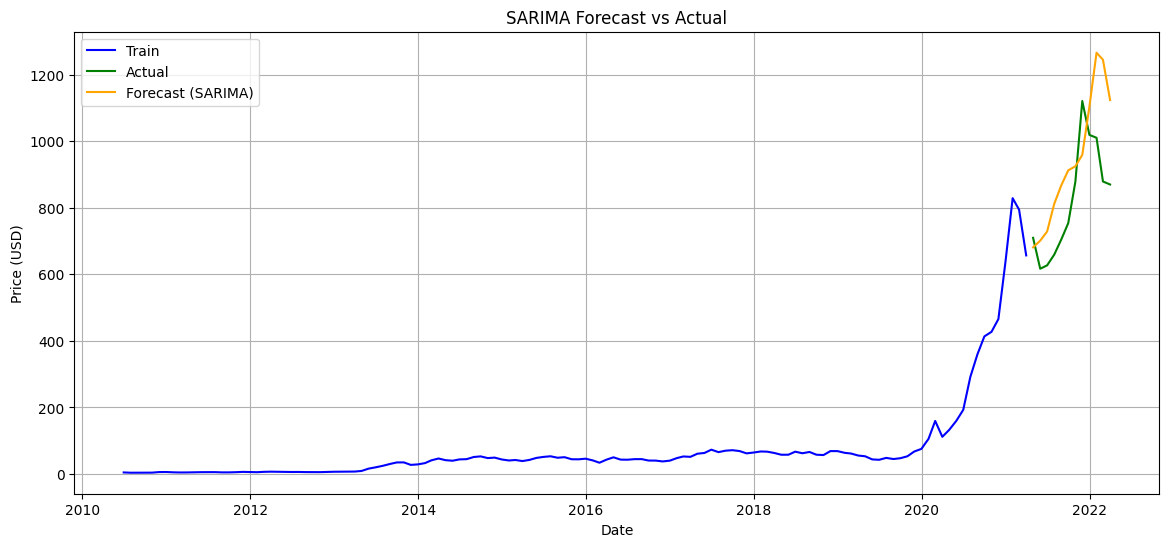

In [21]:
# Plot SARIMA forecast
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label="Train", color='blue')
plt.plot(test.index, test, label="Actual", color='green')
plt.plot(test.index, forecast_sarima, label="Forecast (SARIMA)", color='orange')
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluation Function
def evaluate_forecast(true, predicted, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mae = mean_absolute_error(true, predicted)
    mape = mean_absolute_percentage_error(true, predicted)

    print(f"\n📊 {model_name} Evaluation:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")


In [23]:
# Evaluate ARIMA
evaluate_forecast(test, forecast_arima, model_name="ARIMA(1,1,1)")

# Evaluate SARIMA
evaluate_forecast(test, forecast_sarima, model_name="SARIMA(1,1,1,12)")



📊 ARIMA(1,1,1) Evaluation:
RMSE: 274.59
MAE : 222.39
MAPE: 24.32%

📊 SARIMA(1,1,1,12) Evaluation:
RMSE: 180.77
MAE : 154.72
MAPE: 18.78%


In [24]:
'''
Interpretation:
SARIMA outperforms ARIMA across all evaluation metrics.

Including seasonality (with s=12 for monthly data) captures cyclical patterns in Tesla stock better.

MAPE below 20% for SARIMA is quite decent for stock forecasting.
'''

'\nInterpretation:\nSARIMA outperforms ARIMA across all evaluation metrics.\n\nIncluding seasonality (with s=12 for monthly data) captures cyclical patterns in Tesla stock better.\n\nMAPE below 20% for SARIMA is quite decent for stock forecasting.\n'

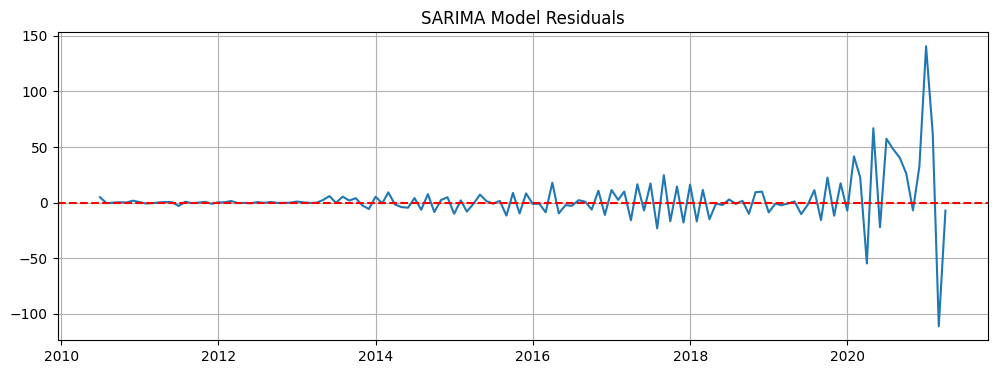

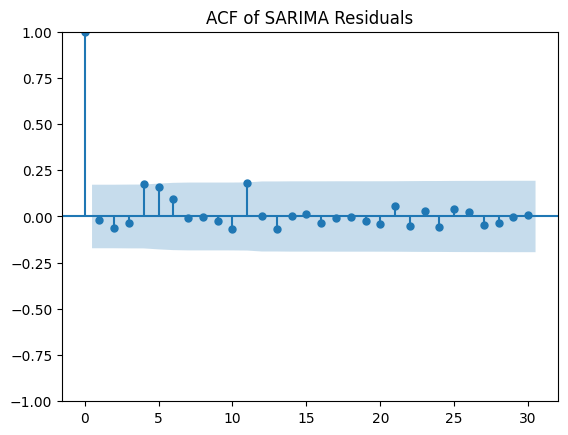

In [25]:
residuals = sarima_result.resid

# Plot residuals
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("SARIMA Model Residuals")
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.show()

# ACF of residuals
plot_acf(residuals.dropna(), lags=30)
plt.title("ACF of SARIMA Residuals")
plt.show()


In [26]:
'''
 Residual Diagnostics (SARIMA)
 1. Residual Plot (Top Chart)
  - The residuals mostly oscillate around zero →  Good sign
  - No strong or systematic trend remains → model has captured the main structure
  - Increased variance post-2020 suggests rising volatility in stock prices, which is expected in financial data

 No strong bias or trend remains → residuals look like white noise

2. ACF of Residuals (Bottom Chart)
 - Most spikes are within the confidence bounds (blue region)
 - A few minor spikes (like at lag 2 or 10), but they’re not statistically significant

 This indicates no strong autocorrelation in residuals
 The model has done a good job of capturing dependencies
'''

'\n Residual Diagnostics (SARIMA)\n 1. Residual Plot (Top Chart)\n  - The residuals mostly oscillate around zero →  Good sign\n  - No strong or systematic trend remains → model has captured the main structure\n  - Increased variance post-2020 suggests rising volatility in stock prices, which is expected in financial data\n\n No strong bias or trend remains → residuals look like white noise\n\n2. ACF of Residuals (Bottom Chart)\n - Most spikes are within the confidence bounds (blue region)\n - A few minor spikes (like at lag 2 or 10), but they’re not statistically significant\n\n This indicates no strong autocorrelation in residuals\n The model has done a good job of capturing dependencies\n'

In [30]:
import pickle

# Save ARIMA model
with open("arima_model_tsa.pkl", "wb") as f:
    pickle.dump((arima_result, df.index[-1]), f)


# Save SARIMA model
with open("sarima_model_tsa.pkl", "wb") as f:
    pickle.dump((sarima_result, df.index[-1]), f)